## 从三体运动到太阳黑子变化预测

### 前言

太阳黑子是太阳光球层上发生的太阳活动现象，通常成群出现。 预测太阳黑子变化是空间气象研究中最活跃的领域之一。 

太阳黑子观测持续时间很长。 长时间的数据积累有利于挖掘太阳黑子变化的规律。 长期观测显示,太阳黑子数及面积变化呈现出明显的周期 性，且周期呈现不规则性,大致范围在 9 ~ 13 a[2] , 平均周期约为 11 a,太阳黑子数及面积变化的峰 值不恒定。 最新数据显示,近些年来太阳黑子数和面积有明显的下降趋势。

![Hathaway_Cycle_24_Prediction](images/Hathaway_Cycle_24_Prediction.png)

鉴于太阳黑子活动强烈程度对地球有着深刻的影响，因此探测太阳黑子活动就显得尤为重要。基于物理学模型(如动力模型[3] )和统计学模型 (如自回归滑动平均[4] )已被广泛应用于探测太阳黑子活动。 为了更高效地捕捉太阳黑子时间序列中存在的非线性关系,机器学习方法被引入。

值得一提的是,机器学习中的神经网络更擅长挖掘数据中的非线性关系。

**因此，本文将介绍如何使用时序数据库`CnosDB`存储太阳黑子变化数据，并进一步使用TensorFlow实现`1DConv+LSTM` 网络来预测太阳黑子数量变化。**


### 太阳黑子变化观测数据集简介

本文使用的太阳黑子数据集是由SILSO 网站发布2.0版本 (WDC-SILSO, Royal Observatory of Belgium, Brussels,http://sidc.be/silso/datafiles)

![sunspot_dataset.png](images/sunspot_dataset.png)


我们主要分析和探索：1749至2023年，月均太阳黑子数(monthly mean sunspot number，MSSN)变化情况。


#### MSSN 数据分析和探索

将 MSSN 数据 csv 格式文件`SN_m_tot_V2.0.csv`（https://www.sidc.be/silso/infosnmtot） 下载到本地。

以下是官方提供的CSV文件描述：

```
Filename: SN_m_tot_V2.0.csv
Format: Comma Separated values (adapted for import in spreadsheets)
The separator is the semicolon ';'.

Contents:
Column 1-2: Gregorian calendar date
- Year
- Month
Column 3: Date in fraction of year.
Column 4: Monthly mean total sunspot number.
Column 5: Monthly mean standard deviation of the input sunspot numbers.
Column 6: Number of observations used to compute the monthly mean total sunspot number.
Column 7: Definitive/provisional marker. '1' indicates that the value is definitive. '0' indicates that the value is still provisional.
```

我们使用 `pandas` 进行文件加载和预览

In [1]:
import pandas as pd

df = pd.read_csv("SN_m_tot_V2.0.csv", sep=";", header=None)
df.columns = ["year", "month", "date_fraction", "mssn", "standard_deviation", "observations", "marker"]

# convert year and month to strings
df["year"] = df["year"].astype(str)
df["month"] = df["month"].astype(str)

# concatenate year and month
df["date"] = df["year"] + "-" + df["month"]

df.head()

,year,month,date_fraction,mssn,standard_deviation,observations,marker,date
0,1749,1,1749.042,96.7,-1.0,-1,1,1749-1
1,1749,2,1749.123,104.3,-1.0,-1,1,1749-2
2,1749,3,1749.204,116.7,-1.0,-1,1,1749-3
3,1749,4,1749.288,92.8,-1.0,-1,1,1749-4
4,1749,5,1749.371,141.7,-1.0,-1,1,1749-5


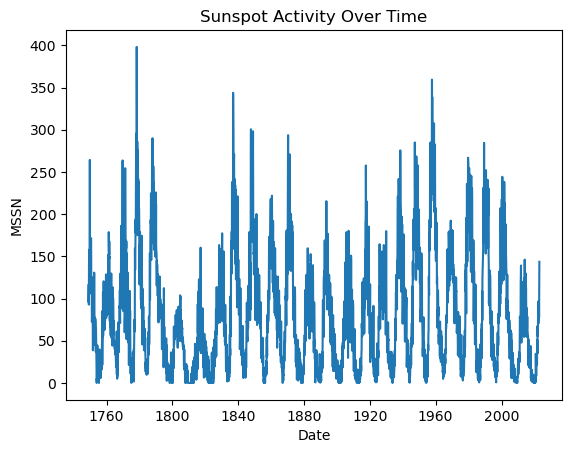

In [2]:
import matplotlib.pyplot as plt 

df["Date"] = pd.to_datetime(df["date"], format="%Y-%m")
plt.plot(df["Date"], df["mssn"])
plt.xlabel("Date")
plt.ylabel("MSSN")
plt.title("Sunspot Activity Over Time")
plt.show()

### 使用时序数据库 CnosDB 存储 MSSN 数据

#### CnosDB 简介

CnosDB（An Open Source Distributed Time Series Database with high performance, high compression ratio and high usability.）

- Official Website: http://www.cnosdb.com
- Github Repo: https://github.com/cnosdb/cnosdb

（注：本文假设你已具备 CnosDB 安装部署和基本使用能力，相关文档详见 https://docs.cnosdb.com/）


在命令行中使用 Docker 启动 CnosDB 数据库服务，并进入容器使用 CnosDB CLI 工具直接访问 CnosDB：
```SHELL
(base) root@ecs-django-dev:~# docker run --restart=always --name cnosdb -d --env cpu=2 --env memory=4 -p 31007:31007 cnosdb/cnosdb:v2.0.2.1-beta

(base) root@ecs-django-dev:~# docker exec -it cnosdb sh sh
# cnosdb-cli
CnosDB CLI v2.0.0
Input arguments: Args { host: "0.0.0.0", port: 31007, user: "cnosdb", password: None, database: "public", target_partitions: None, data_path: None, file: [], rc: None, format: Table, quiet: false }
```

为了简化分析，我们只需存储数据集中观测时间和太阳黑子数。因此，我们将年（Col 0）和月（Col 1）拼接作为观测时间（date, 字符串类型），月均太阳黑子数（Col 3）可以不作处理直接存储。

我们可以在 CnosDB CLI 中使用 SQL 创建一张名为 `sunspot` 数据表，以用于存储 MSSN 数据集。

```SQL
public ❯ CREATE TABLE sunspot (
    date STRING,
    mssn DOUBLE,
);
Query took 0.002 seconds.

public ❯ SHOW TABLES;
+---------+
| Table   |
+---------+
| sunspot |
+---------+
Query took 0.001 seconds.

public ❯ SELECT * FROM sunspot;
+------+------+------+
| time | date | mssn |
+------+------+------+
+------+------+------+
Query took 0.002 seconds.
```

#### 使用 CnosDB Python Connector 连接和读写 CnosDB 数据库

Github Repo: https://github.com/cnosdb/cnosdb-client-python


In [3]:
# 安装 Python Connector
!pip install -U cnos-connector

In [4]:
from cnosdb_connector import connect

conn = connect(url="http://127.0.0.1:31001/", user="root", password="")
cursor = conn.cursor()

如果不习惯使用 CnosDB CLI，我们也可以直接使用 Python Connector 创建数据表

In [5]:
# 创建 tf_demo database
conn.create_database("tf_demo")
# 使用 tf_demo database
conn.switch_database("tf_demo")

In [6]:
print(conn.list_database())

[{'Database': 'tf_demo'}, {'Database': 'usage_schema'}, {'Database': 'public'}]


In [7]:
# 创建 sunspot table
cursor.execute("CREATE TABLE sunspot (date STRING, mssn DOUBLE,);")

In [8]:
print(conn.list_table())

[{'Table': 'sunspot'}]


#### 将 MSSN 数据写入到 CnosDB

In [9]:
df.head()

,year,month,date_fraction,mssn,standard_deviation,observations,marker,date,Date
0,1749,1,1749.042,96.7,-1.0,-1,1,1749-1,1749-01-01
1,1749,2,1749.123,104.3,-1.0,-1,1,1749-2,1749-02-01
2,1749,3,1749.204,116.7,-1.0,-1,1,1749-3,1749-03-01
3,1749,4,1749.288,92.8,-1.0,-1,1,1749-4,1749-04-01
4,1749,5,1749.371,141.7,-1.0,-1,1,1749-5,1749-05-01


In [10]:
conn.write_dataframe(df, "sunspot", ['date', 'mssn'])

df = pd.read_sql("select * from sunspot;", conn)

print(df.head())

     date   mssn                        time
0  1749-1   96.7  2023-03-02T11:56:42.742826
1  1749-2  104.3  2023-03-02T11:56:42.798554
2  1749-3  116.7  2023-03-02T11:56:42.817468
3  1749-4   92.8  2023-03-02T11:56:42.834098
4  1749-5  141.7  2023-03-02T11:56:42.849295


/var/folders/_q/x9yykrrd46b0czsv4rcqcnp40000gn/T/ipykernel_6542/3951511477.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("select * from sunspot;", conn)


### 使用 TensorFlow 复现 1DConv+LSTM 网络，预测太阳黑子变化

参考论文：[程术, 石耀霖, and 张怀. "基于神经网络预测太阳黑子变化." (2022).
](http://journal.ucas.ac.cn/CN/10.7523/j.ucas.2021.0068)

![fig1](images/MSSN.png)



##### 下文将使用TensorFlow 复现论文中的方法，即 `1DConv+LSTM` 神经网络，并根据实际数据来预测月均太阳黑子数（MSSN）变化。


首先将数据集划分为训练集和测试集

In [11]:
import numpy as np
# Convert the data values to numpy for better and faster processing
time_index = np.array(df['date'])
data = np.array(df['mssn'])   

# ratio to split the data
SPLIT_RATIO = 0.8

# Dividing into train-test split
split_index = int(SPLIT_RATIO * data.shape[0])   

# Train-Test Split
train_data = data[:split_index]
train_time = time_index[:split_index]  
test_data = data[split_index:]
test_time = time_index[split_index:]

##### 使用滑动窗口法构造训练数据

![fig3](images/sliding_window_method.png)

In [12]:
import tensorflow as tf

## required parameters
WINDOW_SIZE = 60
BATCH_SIZE = 32
SHUFFLE_BUFFER = 1000

## function to create the input features
def ts_data_generator(data, window_size, batch_size, shuffle_buffer):
    '''
    Utility function for time series data generation in batches
    '''
    ts_data = tf.data.Dataset.from_tensor_slices(data)
    ts_data = ts_data.window(window_size + 1, shift=1, drop_remainder=True)
    ts_data = ts_data.flat_map(lambda window: window.batch(window_size + 1))
    ts_data = ts_data.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    ts_data = ts_data.batch(batch_size).prefetch(1)
    return ts_data# Expanding data into tensors


# Expanding data into tensors
tensor_train_data = tf.expand_dims(train_data, axis=-1)
tensor_test_data = tf.expand_dims(test_data, axis=-1)

## generate input and output features for training and testing set
tensor_train_dataset = ts_data_generator(tensor_train_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
tensor_test_dataset = ts_data_generator(tensor_test_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)

2023-03-02 19:57:58.268040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 19:59:15.615948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 使用 tf.keras 模块定义 1DConv+LSTM 神经网络模型


In [13]:
model = tf.keras.models.Sequential([
                            tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, input_shape=[None, 1]),
                            tf.keras.layers.MaxPool1D(pool_size=2, strides=1),
                        	tf.keras.layers.LSTM(128, return_sequences=True),
                        	tf.keras.layers.LSTM(64, return_sequences=True),  
                        	tf.keras.layers.Dense(132, activation="relu"),  
                        	tf.keras.layers.Dense(1)])

In [14]:
## compile neural network model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
          	optimizer=optimizer,
          	metrics=["mae"])
## training neural network model
history = model.fit(tensor_train_dataset, epochs=20, validation_data=tensor_test_dataset)

Epoch 1/20
81/81 [==============================] - 7s 65ms/step - loss: 7433.4023 - mae: 63.0034 - val_loss: 5102.1440 - val_mae: 57.1819
Epoch 2/20
81/81 [==============================] - 4s 54ms/step - loss: 4611.1958 - mae: 54.1394 - val_loss: 4957.0796 - val_mae: 59.3796
Epoch 3/20
81/81 [==============================] - 5s 54ms/step - loss: 4616.9609 - mae: 54.6070 - val_loss: 4958.4634 - val_mae: 59.4598
Epoch 4/20
81/81 [==============================] - 4s 54ms/step - loss: 4612.7168 - mae: 54.5015 - val_loss: 4955.5854 - val_mae: 59.3983
Epoch 5/20
81/81 [==============================] - 4s 54ms/step - loss: 4602.3901 - mae: 54.3563 - val_loss: 4967.2427 - val_mae: 59.8981
Epoch 6/20
81/81 [==============================] - 4s 54ms/step - loss: 4614.1133 - mae: 54.6332 - val_loss: 4937.0830 - val_mae: 59.5200
Epoch 7/20
81/81 [==============================] - 4s 54ms/step - loss: 4538.5264 - mae: 53.9028 - val_loss: 4695.7964 - val_mae: 57.7491
Epoch 8/20
81/81 [=========

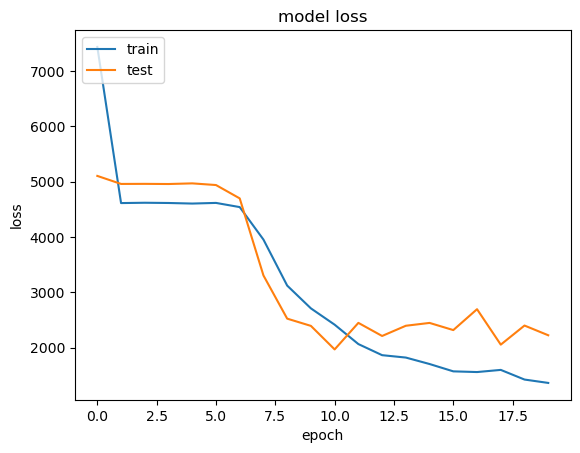

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 使用训练好的模型预测 MSSN


In [16]:
def model_forecast(model, data, window_size):
	ds = tf.data.Dataset.from_tensor_slices(data)
	ds = ds.window(window_size, shift=1, drop_remainder=True)
	ds = ds.flat_map(lambda w: w.batch(window_size))
	ds = ds.batch(32).prefetch(1)
	forecast = model.predict(ds)
	return forecast

rnn_forecast = model_forecast(model, data[..., np.newaxis], WINDOW_SIZE)
rnn_forecast = rnn_forecast[split_index - WINDOW_SIZE:-1, -1, 0]
# Overall Error
error = tf.keras.metrics.mean_absolute_error(test_data, rnn_forecast).numpy()
print(error)

101/101 [==============================] - 2s 18ms/step
24.676455


#### 与真实值对比的可视化结果

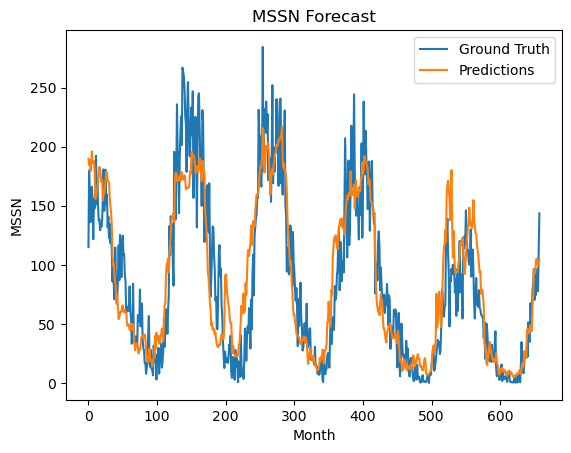

In [17]:
plt.plot(test_data)
plt.plot(rnn_forecast)
plt.title('MSSN Forecast')
plt.ylabel('MSSN')
plt.xlabel('Month')
plt.legend(['Ground Truth', 'Predictions'], loc='upper right')
plt.show()